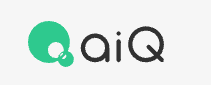

[disclaimer](./disclaimer.txt/)

# aiQ POS Retailer Data Evaluation

- [[?]]aiQ POS Retailer はスーパーマーケット、ドラッグストアやコンピニなどの小売店舗で販売された商品の売上データを TICKER ごとにまとめたものです

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.io

for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

sys.path.append('../..')
from aiq_strategy_robot.data.data_accessor import DAL
from utils.shortcut import aiq_pos_retailer as sc_retailer
from utils.shortcut import common_dataset as sc_common
from utils.shortcut.path import DEFAULT_DIR

## データロード & AltDataEvaluatorの作成

- standard data handler のインスタンスを作成する
- data handler はデータ取得やデータ加工のライブラリを保持するオブジェクト

In [3]:

sdh = DAL()

ここではデータ分析のデモが主眼であるため、個別に用意しておいた簡易ローダーを経由してデータを読み込むこととする

In [4]:
sample_target = "3141-JP"
f_ticker_cvt = lambda s: f"{s[:4]}-JP"
sc_retailer.load_sample_dataset(sdh,  f_ticker_cvt=f_ticker_cvt)
data_id_alt = 1
data_dir = Path(DEFAULT_DIR) / "backup_2024-07-12"
data_id_funda = sc_common.register_fundamental(sdh, data_dir=data_dir)
data_id_mkt = sc_common.register_market(sdh, data_dir=data_dir)
display(sdh.extract_definition)

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,aiq_pos_retailer,Unknown,Unknown,Unknown,"[1925-JP, 2212-JP, 2267-JP, 2651-JP, 2653-JP, ...","[TICKER, DATETIME]",2010-04-30 00:00:00,2024-06-30 00:00:00
2,RawData,mkt,Unknown,Unknown,Unknown2,"[1925 JP, 2212 JP, 2267 JP, 2651 JP, 2653 JP, ...","[TICKER, DATETIME]",2007-01-04 00:00:00,2024-06-19 00:00:00
3,RawData,finnhub,fundamental,Unknown,Unknown3,"[1925 JP, 2212 JP, 2267 JP, 2651 JP, 2653 JP, ...","[TICKER, DATETIME]",2014-06-30 00:00:00,2024-02-29 00:00:00
4,RawData,External,Unknown,Unknown,sales,"[1301-JP, 1332-JP, 1333-JP, 1334-JP, 1352-JP, ...","[TICKER, DATETIME]",2007-04-20 00:00:00,2024-05-31 00:00:00
5,RawData,External,Unknown,Unknown,market,"[1301-JP, 1332-JP, 1333-JP, 1334-JP, 1352-JP, ...","[TICKER, DATETIME]",2007-01-04 00:00:00,2024-07-11 00:00:00


In [5]:
display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.get_raw_data(data_id_mkt).tail())
display(sdh.get_raw_data(data_id_funda).tail())

variable            pos_sales     share
TICKER  DATETIME                       
9994-JP 2024-02-29   2.776912  0.368321
        2024-03-31   3.163767  0.368726
        2024-04-30   3.130022  0.393859
        2024-05-31   3.108171  0.420301
        2024-06-30   3.168573  0.394184

close
TICKER  DATETIME         
9997-JP 2024-07-05  807.0
        2024-07-08  812.0
        2024-07-09  814.0
        2024-07-10  794.0
        2024-07-11  812.0

sales
TICKER  DATETIME           
9997-JP 2023-03-31  51922.0
        2023-06-30  51842.0
        2023-09-30  44263.0
        2023-12-31  60173.0
        2024-03-31  52020.0

### AltDataEvaluatorを作成

In [6]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

## 相関計算

### 四半期売上高との相関を計算

> 売上高の時系列幅に合わせてリサンプルします.

In [7]:
sdh.get_raw_data(data_id_funda)

sales
TICKER  DATETIME           
1301-JP 2007-06-30  37204.0
        2007-09-30  37340.0
        2007-12-31  41534.0
        2008-03-31  31689.0
        2008-06-30  36678.0
...                     ...
9997-JP 2023-03-31  51922.0
        2023-06-30  51842.0
        2023-09-30  44263.0
        2023-12-31  60173.0
        2024-03-31  52020.0

[37998 rows x 1 columns]

In [8]:
sdh.transform.clear()
funda_kpi_id = sdh.transform.raw(data_id=data_id_funda, fields='sales').variable_ids[0]
pos_Q_ids = sdh.transform.resample_by(label=funda_kpi_id, func='last', data_id=data_id_alt).variable_ids

#### 四半期売上高とのプロット

ハンドラの`show_line_one_target`で、特定TickerのKPI(y)とTruValuデータとのプロットを行います.

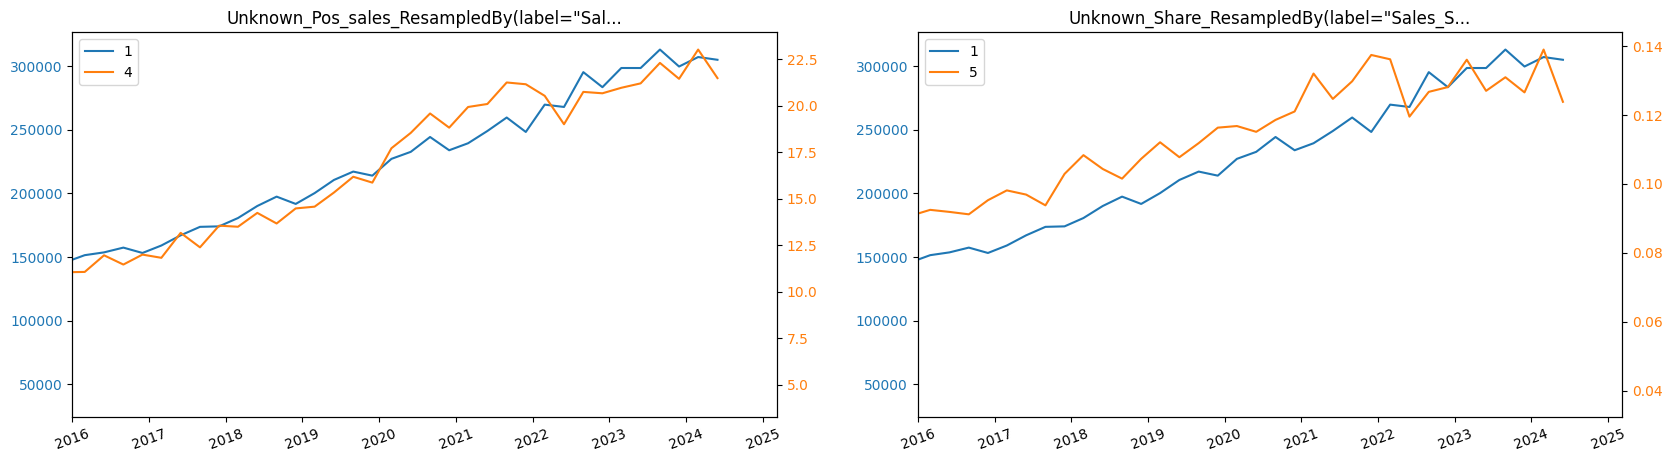

In [9]:
sdh.show_line_one_target(
    target=sample_target,
    y=funda_kpi_id,
    X= pos_Q_ids[:],
    col_num=2,
    vname_len_limit=40,
    start_date='2016-01-01'
)

> データの時系列をshiftすることで売上高とのプロットがどのように変化するかを見ます.

#### ベースとなる `variable` から変数を作成し、財務とマッチするのはどの変数か視覚的に確認できるようにします
- `sdh.transform` を使うことで様々な変数を作成し、どの変数が一番財務と関係性が強いのか一気に検証を行うことができます。
- `transform` の処理一覧は `data handler` のサンプル notebook を確認してください。

In [10]:

shft1_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample_by(label=funda_kpi_id, func='last').variable_ids
shft2_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample_by(label=funda_kpi_id, func='last').variable_ids
shft3_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample_by(label=funda_kpi_id, func='last').variable_ids
shft4_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample_by(label=funda_kpi_id, func='last').variable_ids
shft5_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=5).resample_by(label=funda_kpi_id, func='last').variable_ids
shft6_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=6).resample_by(label=funda_kpi_id, func='last').variable_ids
shft7_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=7).resample_by(label=funda_kpi_id, func='last').variable_ids
shft8_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=8).resample_by(label=funda_kpi_id, func='last').variable_ids
shft9_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=9).resample_by(label=funda_kpi_id, func='last').variable_ids
shft10_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=10).resample_by(label=funda_kpi_id, func='last').variable_ids
shft11_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=11).resample_by(label=funda_kpi_id, func='last').variable_ids
shft12_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=12).resample_by(label=funda_kpi_id, func='last').variable_ids
shft13_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=13).resample_by(label=funda_kpi_id, func='last').variable_ids
shft14_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=14).resample_by(label=funda_kpi_id, func='last').variable_ids
shft15_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=15).resample_by(label=funda_kpi_id, func='last').variable_ids
shft16_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=16).resample_by(label=funda_kpi_id, func='last').variable_ids

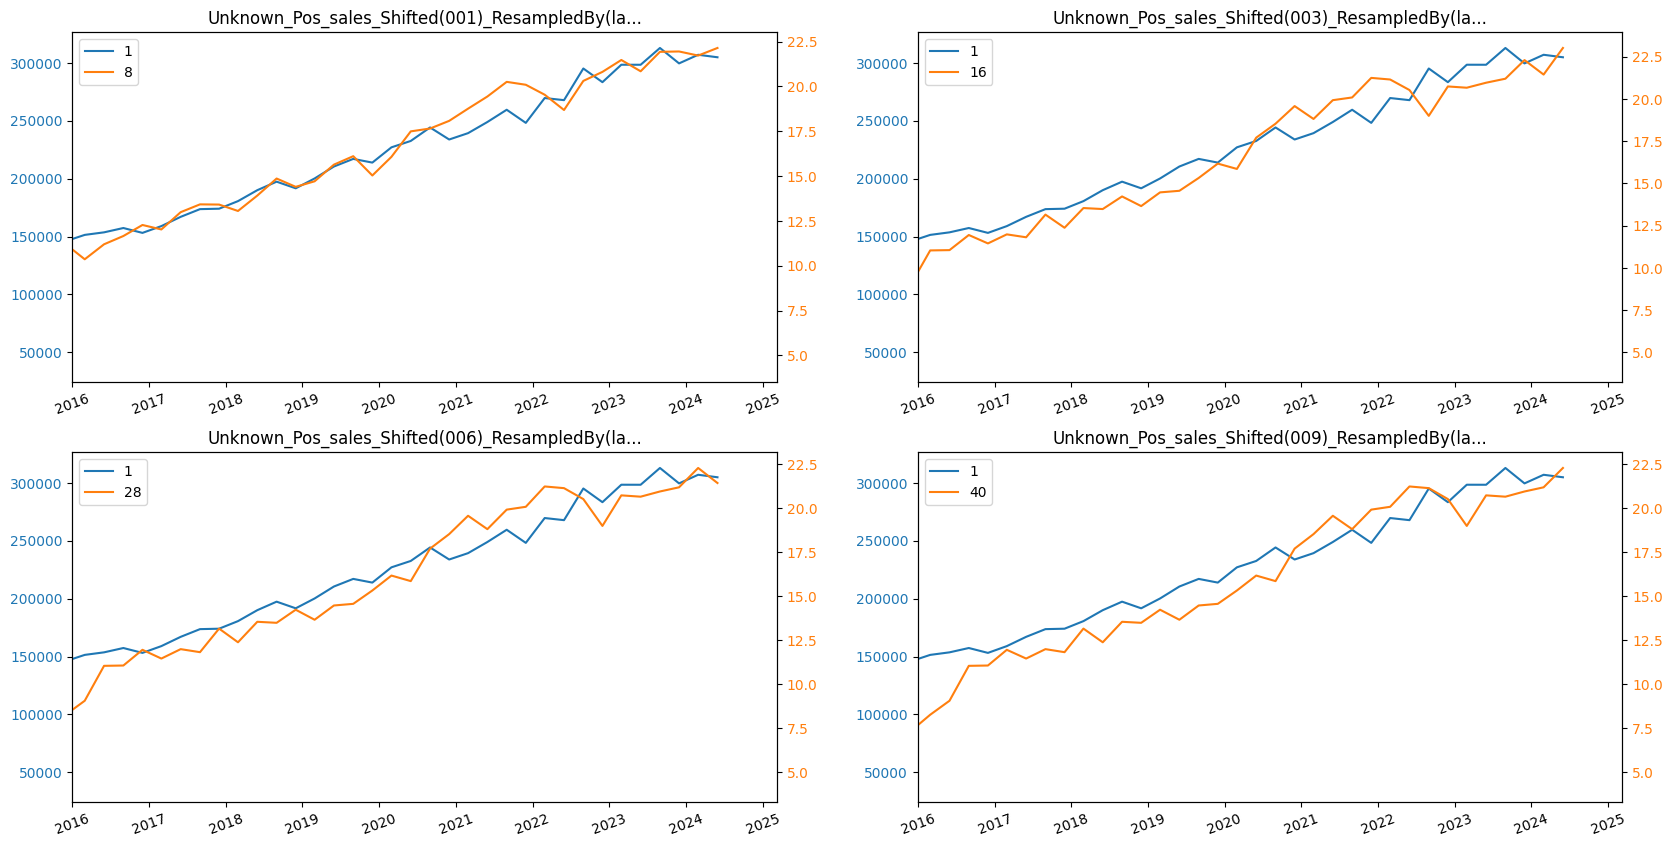

In [11]:
sdh.show_line_one_target(
    target=sample_target,
    y=funda_kpi_id,
    X= [shft1_Q_ids[0], shft3_Q_ids[0], shft6_Q_ids[0], shft9_Q_ids[0]],
    col_num=2,
    vname_len_limit=45,
    start_date='2016-01-01'
)

> 特徴量を対数変換して相関計算を行います


In [12]:
funda_kpi_log_id = sdh.transform.log_diff(fields=funda_kpi_id, periods=4).diff(periods=1).variable_ids[-1]

shft0_Q_log_ids = sdh.transform.log_diff(fields=pos_Q_ids, periods=4).diff(periods=1).variable_ids
shft1_Q_log_ids = sdh.transform.log_diff(fields=shft1_Q_ids, periods=4).diff(periods=1).variable_ids
shft2_Q_log_ids = sdh.transform.log_diff(fields=shft2_Q_ids, periods=4).diff(periods=1).variable_ids
shft3_Q_log_ids = sdh.transform.log_diff(fields=shft3_Q_ids, periods=4).diff(periods=1).variable_ids
shft4_Q_log_ids = sdh.transform.log_diff(fields=shft4_Q_ids, periods=4).diff(periods=1).variable_ids
shft5_Q_log_ids = sdh.transform.log_diff(fields=shft5_Q_ids, periods=4).diff(periods=1).variable_ids
shft6_Q_log_ids = sdh.transform.log_diff(fields=shft6_Q_ids, periods=4).diff(periods=1).variable_ids
shft7_Q_log_ids = sdh.transform.log_diff(fields=shft7_Q_ids, periods=4).diff(periods=1).variable_ids
shft8_Q_log_ids = sdh.transform.log_diff(fields=shft8_Q_ids, periods=4).diff(periods=1).variable_ids
shft9_Q_log_ids = sdh.transform.log_diff(fields=shft9_Q_ids, periods=4).diff(periods=1).variable_ids
shft10_Q_log_ids = sdh.transform.log_diff(fields=shft10_Q_ids, periods=4).diff(periods=1).variable_ids
shft11_Q_log_ids = sdh.transform.log_diff(fields=shft11_Q_ids, periods=4).diff(periods=1).variable_ids
shft12_Q_log_ids = sdh.transform.log_diff(fields=shft12_Q_ids, periods=4).diff(periods=1).variable_ids
shft13_Q_log_ids = sdh.transform.log_diff(fields=shft13_Q_ids, periods=4).diff(periods=1).variable_ids
shft14_Q_log_ids = sdh.transform.log_diff(fields=shft14_Q_ids, periods=4).diff(periods=1).variable_ids
shft15_Q_log_ids = sdh.transform.log_diff(fields=shft15_Q_ids, periods=4).diff(periods=1).variable_ids
shft16_Q_log_ids = sdh.transform.log_diff(fields=shft16_Q_ids, periods=4).diff(periods=1).variable_ids

#### 相関計算

In [13]:
ori_cols = sdh.get_raw_data(data_id_alt).columns
ori_cols

Index(['pos_sales', 'share'], dtype='object', name='variable')

In [14]:
rho_pool = pd.DataFrame()
rho_pool['shift=0'] = ade.compu_rho(shft0_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=1'] = ade.compu_rho(shft1_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=2'] = ade.compu_rho(shft2_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=3'] = ade.compu_rho(shft3_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=4'] = ade.compu_rho(shft4_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=5'] = ade.compu_rho(shft5_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=6'] = ade.compu_rho(shft6_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=7'] = ade.compu_rho(shft7_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=8'] = ade.compu_rho(shft8_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=9'] = ade.compu_rho(shft9_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=10'] = ade.compu_rho(shft10_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=11'] = ade.compu_rho(shft11_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=12'] = ade.compu_rho(shft12_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=13'] = ade.compu_rho(shft13_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=14'] = ade.compu_rho(shft14_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=15'] = ade.compu_rho(shft15_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=16'] = ade.compu_rho(shft16_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)

display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

,shift=0,shift=1,shift=2,shift=3,shift=4,shift=5,shift=6,shift=7,shift=8,shift=9,shift=10,shift=11,shift=12,shift=13,shift=14,shift=15,shift=16
pos_sales,10.135079,10.454646,10.230462,-1.250889,-3.016403,-2.321851,0.579059,-0.572987,-1.069523,-0.633116,1.765697,1.609890,-3.540956,-4.306003,-4.696405,-0.031843,0.798415
share,6.334899,6.317352,4.139321,-0.342508,-2.549420,-0.199172,0.128439,0.212838,-1.838554,-0.868670,0.671714,1.465918,-1.335532,-3.272164,-2.342595,-0.531416,2.162647


In [15]:
display(rho_pool.xs('rho', level=1).sort_values(rho_pool.columns[0], ascending=False))

,shift=0,shift=1,shift=2,shift=3,shift=4,shift=5,shift=6,shift=7,shift=8,shift=9,shift=10,shift=11,shift=12,shift=13,shift=14,shift=15,shift=16
pos_sales,0.136603,0.141082,0.138864,-0.017227,-0.041582,-0.032194,0.008076,-0.008007,-0.015028,-0.008944,0.02499,0.022918,-0.050624,-0.061643,-0.067611,-0.000462,0.011605
share,0.085873,0.085794,0.056644,-0.004718,-0.035154,-0.002763,0.001791,0.002974,-0.025828,-0.012272,0.00951,0.020869,-0.019115,-0.046881,-0.033783,-0.007709,0.031420


> もっとも相関の良い変数のうち、さらに上記N件のTickerを確認します.

In [16]:
rho_time = ade.compu_rho(shft1_Q_log_ids, funda_kpi_log_id, by='ticker', rename_features=ori_cols)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

,pos_sales,share
TICKER,,
2678-JP,5.552061,5.439125
9989-JP,5.541972,1.269612
3098-JP,5.128900,3.047334
3088-JP,4.876140,2.669191
2791-JP,4.790108,5.505698


> 変数を確認して散布図でplot

In [17]:
display(sdh.transform.find_variables(shft1_Q_log_ids))

feature = 76 # pos_sales

,variable_id,data_id,data_source,source,table,field,ticker,reference_id,variable_type,method,params,process_id
variable_name,,,,,,,,,,,,
"Unknown_Pos_sales_Shifted(001)_ResampledBy(label=""Sales_Sales"", func=""last"")_LogDiff(004)_Diff(001)",78,1,aiq_pos_retailer,Unknown,Unknown,Unknown_Pos_sales_Shifted(001)_ResampledBy(lab...,None,76,feature,diff,periods=1,41
"Unknown_Share_Shifted(001)_ResampledBy(label=""Sales_Sales"", func=""last"")_LogDiff(004)_Diff(001)",79,1,aiq_pos_retailer,Unknown,Unknown,"Unknown_Share_Shifted(001)_ResampledBy(label=""...",None,77,feature,diff,periods=1,41


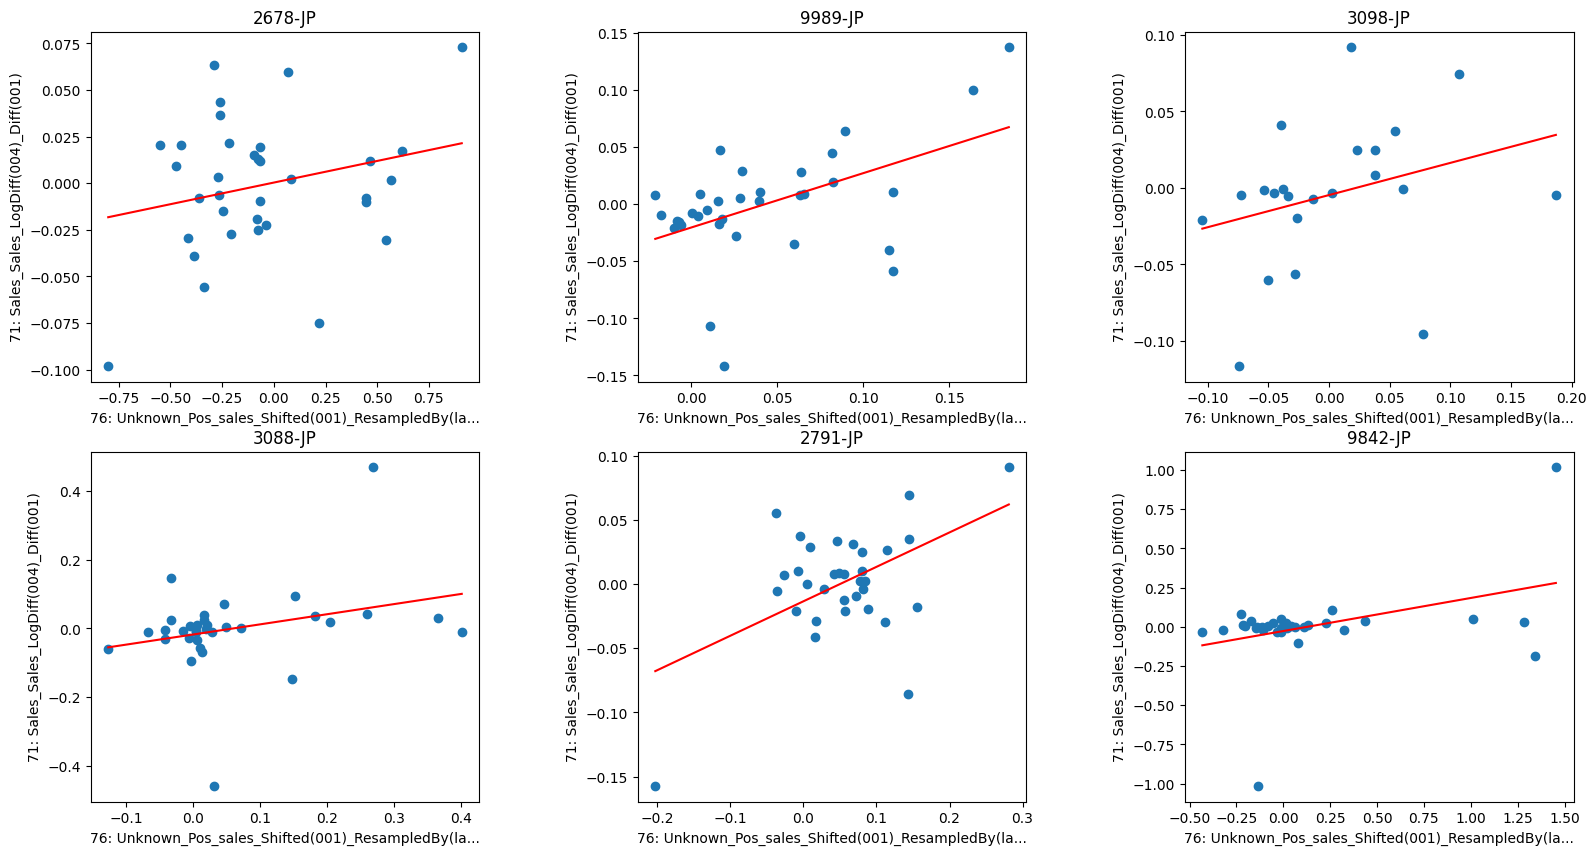

In [18]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=funda_kpi_log_id,
    x=feature,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=45,
    start_date='2016-01-01'
)

### 株価変化率との相関

- 財務と POS Retailerの高い関連性が確認できたため、次は株価変化率との関連性を調べます

> 月次データにリサンプル

In [19]:
resample_term = 'M'
n_rolling = 2  # 2 months rolling mean

pos_sales_and_share = sdh.transform.resample(data_id=data_id_alt, rule=resample_term, func='last', names=["pos_sales", "share"]).variable_ids
pos_sales_vs_share = sdh.transform.multiply(x1field=pos_sales_and_share[0], x2field=pos_sales_and_share[1], name='pos_sales * share').variable_ids[0]
alt_M_ids = sdh.transform.sma(n_rolling, fields=pos_sales_and_share+[pos_sales_vs_share]).variable_ids # pos_sales, share, pos_sales * share
mkt_M_close_id = sdh.transform.resample('D', 'last', data_id=data_id_mkt, fields='close').fillna('ffill').shift(-7).reindex(label=alt_M_ids[0]).variable_ids[-1]

In [20]:
alt_names = ["pos_sales", "share", "pos_sales * share"]

> 価格データとposデータをVisualtize

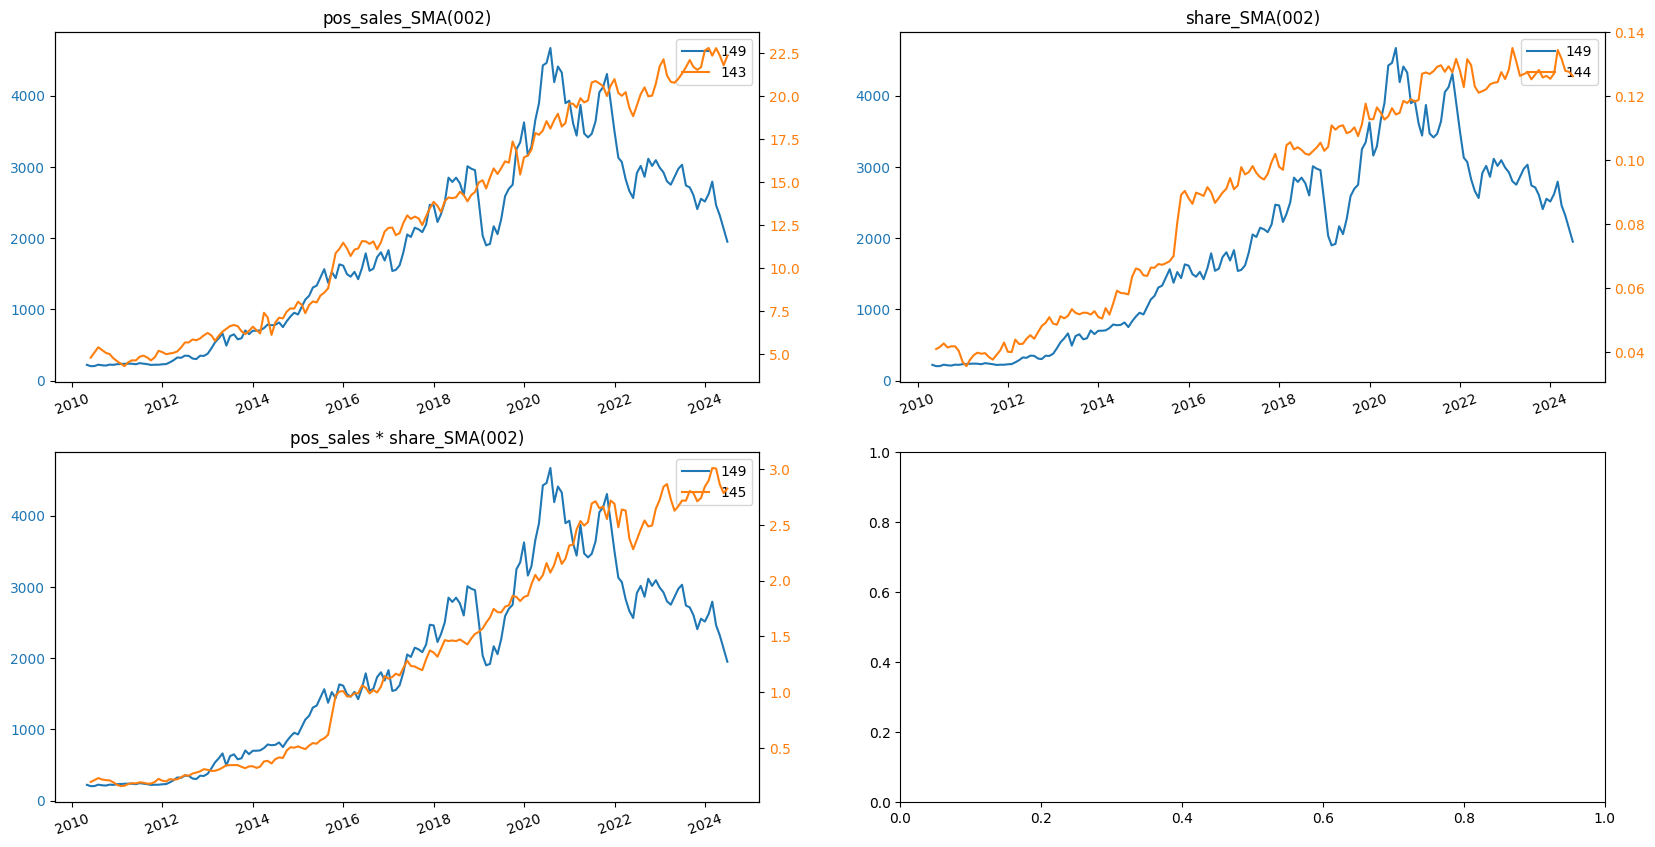

In [21]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_M_close_id,
    X= alt_M_ids[:4],
    col_num=2,
    vname_len_limit=40,
)

> データの時系列をshiftすることで売上高とのプロットがどのように変化するかを見ます.

In [22]:
shift1_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=1).variable_ids
shift2_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=2).variable_ids
shift3_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=3).variable_ids
shift4_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=4).variable_ids
shift5_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=5).variable_ids
shift6_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=6).variable_ids
shift7_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=7).variable_ids
shift8_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=8).variable_ids

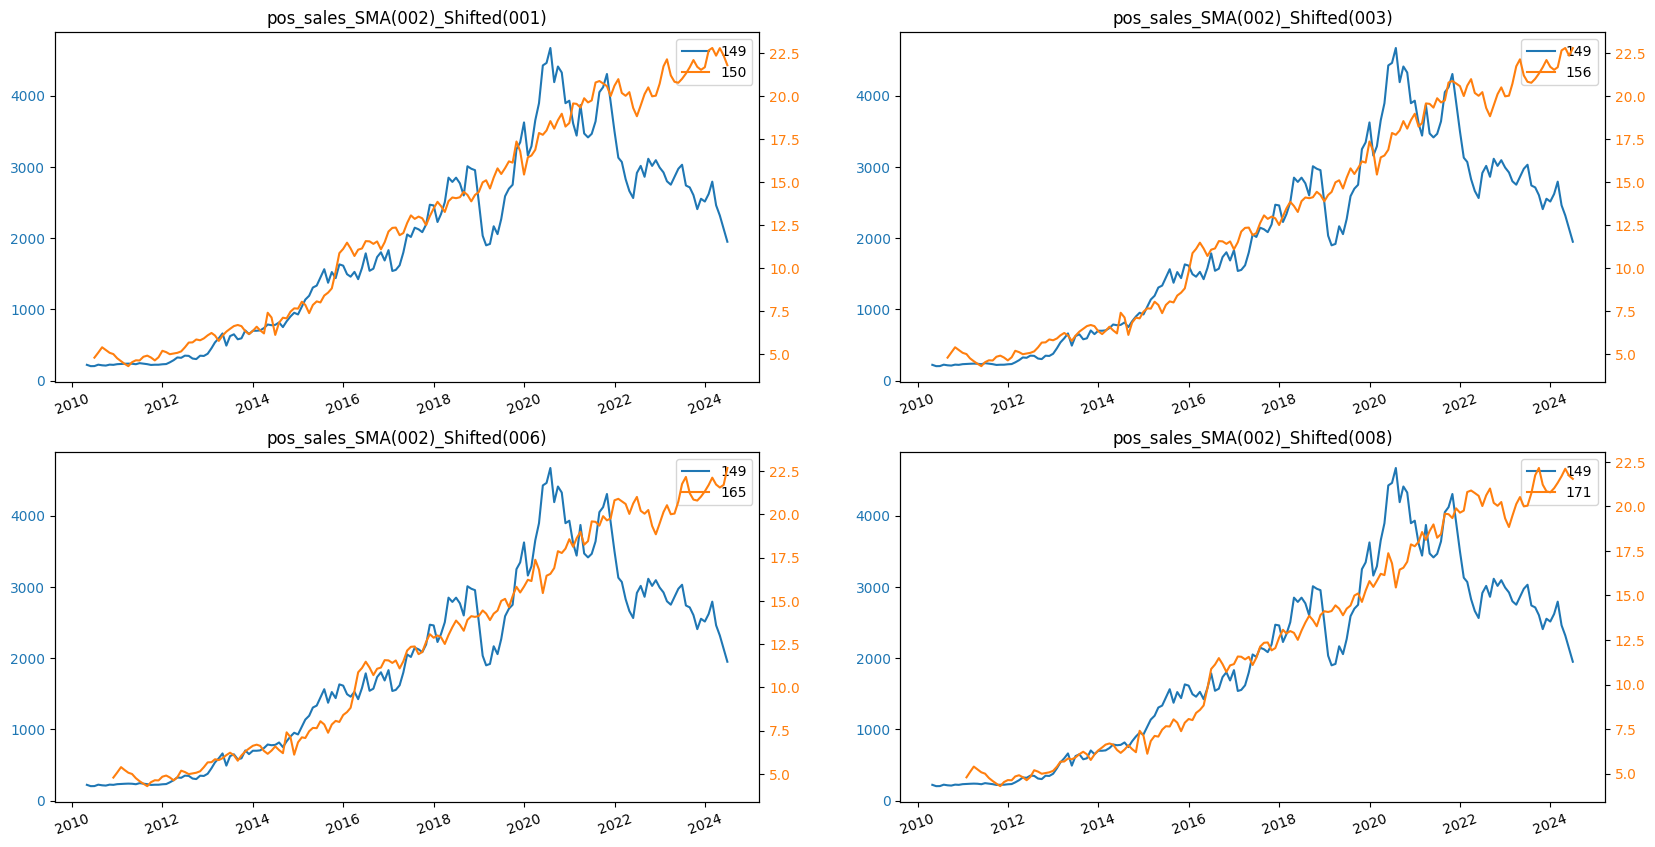

In [23]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_M_close_id,
    X= [shift1_M_ids[0], shift3_M_ids[0], shift6_M_ids[0], shift8_M_ids[0]],
    col_num=2,
    vname_len_limit=45,
)

> 特徴量を対数変換して相関計算を行う.

In [24]:
close_return = sdh.transform.dropna(fields=mkt_M_close_id).log_diff(1).variable_ids[-1]

In [25]:

n_diff = 12  # 12 months (1 year) difference
log_shift0_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).variable_ids
log_shift1_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=1).variable_ids
log_shift2_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=2).variable_ids
log_shift3_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=3).variable_ids
log_shift4_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=4).variable_ids
log_shift5_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=5).variable_ids
log_shift6_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=6).variable_ids
log_shift7_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=7).variable_ids
log_shift8_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=8).variable_ids

In [26]:
rho_pool = pd.DataFrame()
rho_pool['shift=0'] = ade.compu_rho(log_shift0_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=1'] = ade.compu_rho(log_shift1_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=2'] = ade.compu_rho(log_shift2_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=3'] = ade.compu_rho(log_shift3_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=4'] = ade.compu_rho(log_shift4_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=5'] = ade.compu_rho(log_shift5_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=6'] = ade.compu_rho(log_shift6_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=7'] = ade.compu_rho(log_shift7_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=8'] = ade.compu_rho(log_shift8_M_ids, close_return, rename_features=alt_names)

display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

,shift=0,shift=1,shift=2,shift=3,shift=4,shift=5,shift=6,shift=7,shift=8
pos_sales,5.960559,6.356474,3.209822,1.825005,1.254803,-0.227992,2.658138,2.488867,1.158541
pos_sales * share,5.605524,6.003754,2.875165,2.267956,1.821326,0.395134,2.921235,2.327470,1.735079
share,4.602466,4.688543,2.233092,2.566137,2.359446,0.891965,2.467934,2.136083,2.118348


> もっとも相関の良い変数のうち、さらに上記N件のTickerを確認します.

In [27]:
rho_time = ade.compu_rho(log_shift1_M_ids, close_return, by='ticker', rename_features=alt_names)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

,pos_sales * share,pos_sales,share
TICKER,,,
3141-JP,3.302242,3.318795,2.760325
3337-JP,2.719381,2.694115,1.682863
3349-JP,2.301445,2.522879,2.082746
8167-JP,1.746024,2.392722,1.171651
3080-JP,2.071947,2.314303,1.770352


> 変数を確認して散布図でplot

In [28]:
display(sdh.transform.find_variables(log_shift1_M_ids))

feature = 177 # pos_sales

,variable_id,data_id,data_source,source,table,field,ticker,reference_id,variable_type,method,params,process_id
variable_name,,,,,,,,,,,,
pos_sales_SMA(002)_LogDiff(012)_Shifted(001),179,1,aiq_pos_retailer,Unknown,Unknown,pos_sales_SMA(002)_LogDiff(012),None,176,feature,shift,periods=1,90
share_SMA(002)_LogDiff(012)_Shifted(001),180,1,aiq_pos_retailer,Unknown,Unknown,share_SMA(002)_LogDiff(012),None,177,feature,shift,periods=1,90
pos_sales * share_SMA(002)_LogDiff(012)_Shifted(001),181,1,aiq_pos_retailer,Unknown,Unknown,pos_sales * share_SMA(002)_LogDiff(012),None,178,feature,shift,periods=1,90


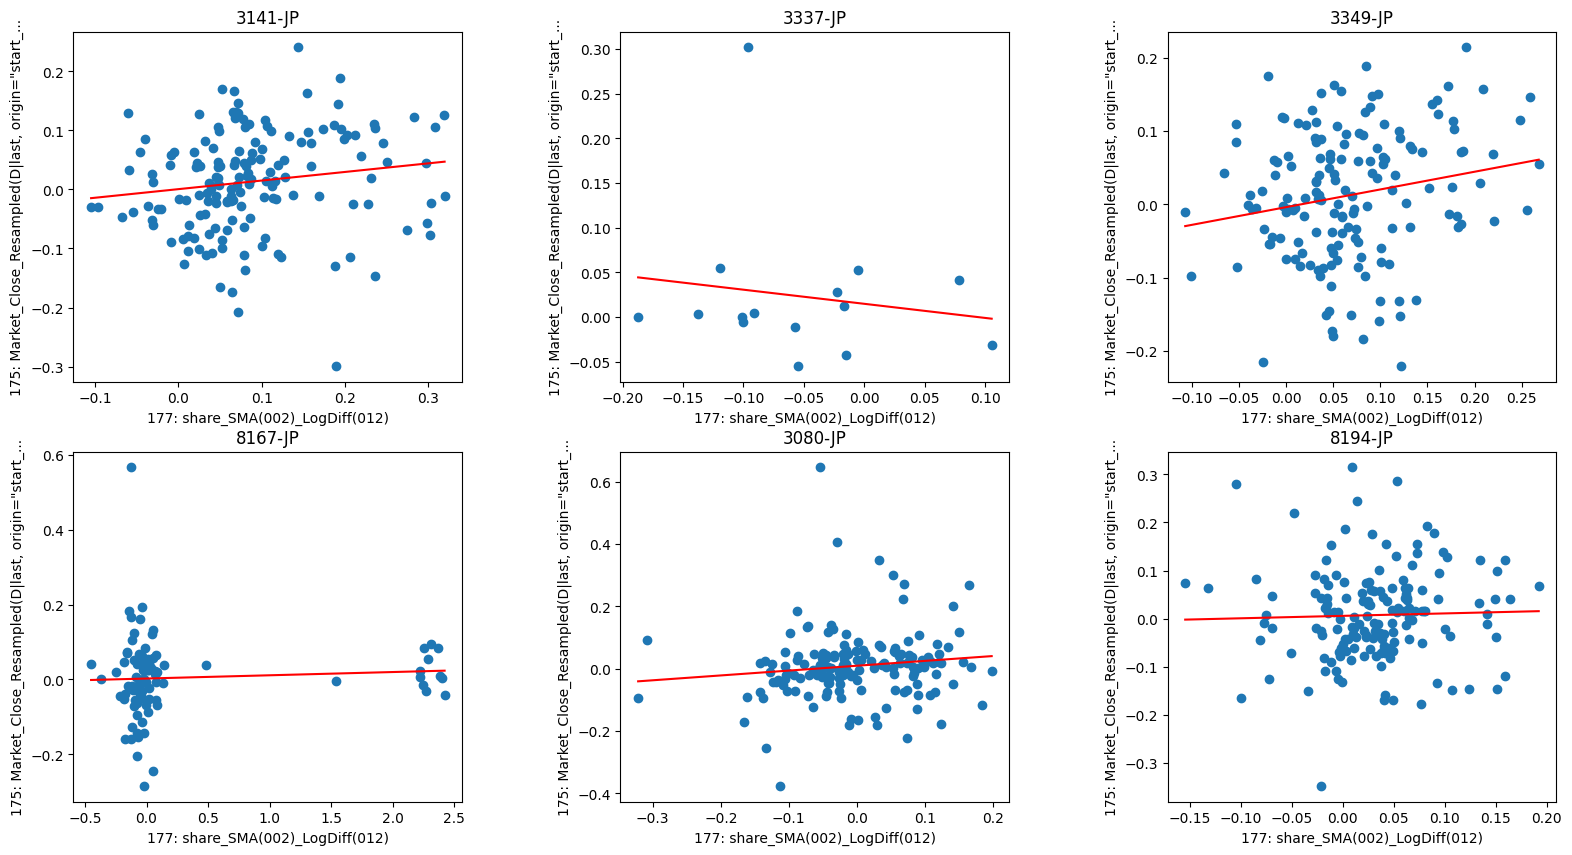

In [29]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=close_return,
    x=feature,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=45
)

## バックテスト
> 株価変化率ともっとも相関の良い特徴量をシグナルにして、ポートフォリオ分析を実施します.

- 1.2で作成した変数をベースに、様々なファクターを作成して計算を行っていきます。
- ここでは12週移動平均をとった pos_sales の変数をファクター値に選んでいます。
- 実務では移動平均値やシフト幅などのハイパーパラメータを変動させることで、バックテストの結果が大きく影響を受けないことを確認します。

In [30]:
# define the parameters for factor choice.
nq = 3
exe_cost = 0.0005

In [31]:
dfqret, stats, dfsigqt = ade.q_backtest(
    feature,
    close_return,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,0.651202,0.049736,0.133852,0.371575,0.588608,3.173432,-0.346483,0.143545
#2,0.976912,0.074612,0.129246,0.577289,0.626582,4.539002,-0.325342,0.229335
#3,1.558595,0.119039,0.138726,0.858084,0.658228,3.311368,-0.232495,0.512007
#3-#1,0.907393,0.069303,0.062970,1.100564,0.645570,6.484800,-0.056470,1.227256
#3-#1(cost),0.864939,0.066060,0.062963,1.049195,0.639241,6.484800,-0.057546,1.147953
